In [1]:
# Run these separately to install the required libraries
#If needed any other install that like this
!pip install hdbscan
!pip install basemap
!pip install folium
!pip install numpy
!pip install pandas
!pip install nltk
!pip install matplotlib

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saisu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saisu\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\saisu\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\saisu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [16]:
#Textual Metadata Processing

import csv
import nltk
import numpy as np
import pandas as pd
from collections import defaultdict
from nltk.tokenize import sent_tokenize, word_tokenize,RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import os

# Specify directory and convert to CSV
import pandas as pd
location=r"Results\Input Records\Filtered1M.csv"
data = pd.read_csv(location, header=None)
data.to_csv(r"Results\TextualMetadataProcessing\TP1M.csv",columns=[0,1,3,5,12,13,14],index=False,header=['LineNo','PhotoID','UserID','DateTaken','Latitude','Longitude','Accuracy'])

# Change file name
location=r"Results\Input Records\Filtered1M.csv"
dest = r"Results\TextualMetadataProcessing\TP1M.csv"
data = pd.read_csv(location, header=None)
tokenizer = RegexpTokenizer(r'[a-zA-Z_]+')
data2 = pd.read_csv(dest
                   )
data2['Tags'] = ""
Info=[]
tagPid=defaultdict(list)

In [17]:

from nltk.corpus import stopwords

#Selecting appropriate metadata
for i in range(0,len(data.index)):
    user_tag=str(data[10][i])
    user_tag+=str(data[8][i])
    user_tag+=str(data[9][i])
    filtered = []
    filtered = list(set(filtered + tokenizer.tokenize(user_tag)))


    # removing stop words
    stop_words = set(stopwords.words('english'))
    stop_removed =[]
    for w in filtered:
        if w not in stop_words:
            stop_removed.append(w)

    # reducing words to their root form
    stemmed=[]
    lemmatizer = WordNetLemmatizer()
    for w in stop_removed:
        stemmed.append(lemmatizer.lemmatize(w))

    # obtain only nouns
    nouns = []
    for w in stemmed:
        for word,pos in nltk.pos_tag([w]):
             if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):
                nouns.append(w)

    #Appending words in root form to file
    k=""
    final = list(set(nouns))
    for g in final:
        k+=g
        if g in tagPid.keys():
            tagPid[g].append(data[1][i])
        else:
            tagPid[g].append(data[1][i])
        k+=" "
    Info+=final
    
    data2["Tags"][i]=k
Info=list(set(Info))

C:\Users\saisu\AppData\Local\Temp\ipykernel_18072\2573075255.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2["Tags"][i]=k


In [18]:
import os
data2.to_csv("Results/Input records/Textproc1M.csv",index=False)
newfile= "Results/Input records/Textproc1M.csv"
newframe = pd.read_csv(newfile)

#Binary vector to find which all tags have been used
bv = np.zeros((26710, len(Info)), dtype=int)

int_tags={}
for w in Info:
    int_tags[w]=0
tags=newframe.Tags
for s in tags:
    i = 0
    l = s.split(" ")
    count = 0
    for w in Info:
        if w in l:
            count += 1
            bv[i][Info.index(w)] = 1
        int_tags[w] += 1
        i += 1

            
#Filtering tags which appear more than 1 time
i=0
count=0
for i in int_tags.keys():
    if int_tags[i] > 1:
        count+=1
#Finding the interesting words based on threshold
interested={}
threshold = 1/len(newframe)
for w in Info:

    if int_tags[w]/len(newframe) > threshold:
        interested[w] = int_tags[w]/len(Info)
#Finding photo ID corresponding to interesting words
photo_id=[]
for w in interested.keys():
    photo_id=list(set(photo_id+tagPid[w]))
df=newframe.query('PhotoID in @photo_id')  
df = newframe.query('PhotoID in @photo_id')
output_path = r"Results/TextualMetadataProcessing"  # Use raw string or escape backslashes
TP_op1M = 'TP_op1M.csv'
file_path = os.path.join(output_path, TP_op1M)
df.to_csv(file_path, columns=['PhotoID', 'UserID', 'Latitude', 'Longitude', 'Accuracy'], index=False, header=['PhotoID', 'UserID', 'Latitude', 'Longitude', 'Accuracy'])

print('TP_op1M csv file is created in the Results folder for further processing')

TP_op1M csv file is created in the Results folder for further processing


In [11]:
pip install hdbscan

Note: you may need to restart the kernel to use updated packages.


In [19]:
# Geographical Data Clustering
import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import hdbscan
import folium
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors

# Loading CSV File (Output of Text processing step)
input_file = "Results/TextualMetadataProcessing/TP_op1M.csv"
df = pd.read_csv(input_file)
df1 = df.copy()
coord = {}
Lat = np.asarray(df['Latitude'])
Long = np.asarray(df['Longitude'])
coords = df[['Longitude', 'Latitude']].values
rads = np.radians(coords)


# Clustering step
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0,metric='haversine', gen_min_span_tree=True, min_cluster_size=20, min_samples=None, p=None).fit(rads)
cluster_labels = clusterer.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters)])
cluster_label=(clusterer.labels_)
x = cluster_label
cluster_points={}
for i in range(num_clusters + 1):
    cluster_points[i] = []
    
cluster_points[-1]=[]

for i in range(0,len(x)):
    l = cluster_points[x[i]]
    l.append(coords[i])
    cluster_points[x[i]] = l

plt.figure(figsize=(12, 12))

# Plotting points on map
m = Basemap(projection='merc', resolution='l', epsg=4269, llcrnrlon=-122.567288, llcrnrlat=37.696627, urcrnrlon=-122.329308, urcrnrlat=37.852144)
x, y = m(coords[:, 1], coords[:, 0])
m.scatter(x, y, 5, marker='o', color='b')
m.arcgisimage(service='World_Shaded_Relief', xpixels=5000, verbose=False)
plt.show()

def get_cmap(N):
    '''
    Returns a function that maps each index in 0, 1, ... N-1 to a distinct 
    RGB color.
    '''
    color_norm = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='nipy_spectral')
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

plt.figure(figsize=(12, 12))

m = Basemap(projection='merc', resolution='l', epsg=4269, llcrnrlon=-122.567288, llcrnrlat=37.696627, urcrnrlon=-122.329308, urcrnrlat=37.852144)

unique_label = np.unique(cluster_labels)
cmaps = get_cmap(num_clusters)

for i, cluster in enumerate(clusters):
    lons_select = cluster[:, 1]
    lats_select = cluster[:, 0]
    x, y = m(lons_select, lats_select)
    m.scatter(x, y, 5, marker='o', color=cmaps(i), zorder=10)

m.arcgisimage(service='World_Shaded_Relief', xpixels=5000, verbose=False)
plt.show()

# Finding Cluster representatives


TypeError: 'numpy.float64' object cannot be interpreted as an integer

C:\Users\saisu\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.82554e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\saisu\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.87252e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\saisu\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e+03, tolerance: 1.841e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\saisu\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

5.570096763663404

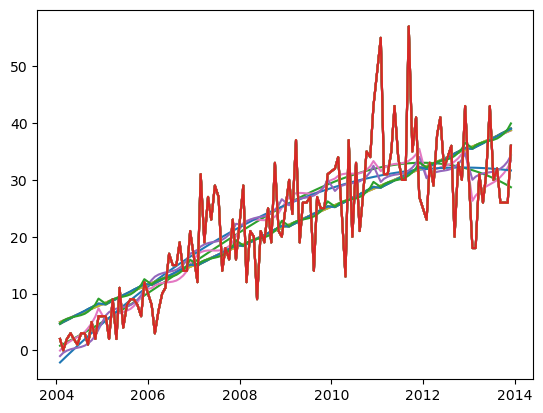

In [20]:
# Trend Analysis


import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline
from sklearn import linear_model as lm

regr = lm.LinearRegression()
clf = Lasso(alpha=0.1)

# Loading CSV corresponding to a particular region
df = pd.read_csv(r"Results/TrendEstimation/fullaustralia.csv", header=None)
df2 = pd.to_datetime(df[5])
months = list(range(1, 13))
years = list(range(2004, 2014))
df[5] = pd.to_datetime(df[5])
ct = []

X_my = []
for year in years:
    for month in months:
        l = [month, year]
        X_my.append(l)
        ct.append(len(df.loc[operator.and_(df[5].dt.year == year, df[5].dt.month == month)]))

df[5] = pd.to_datetime(df[5])
ct_test = []
X_my_test = []
year = 2014
for month in months:
    l = [month, year]
    X_my_test.append(l)
    ct_test.append(len(df.loc[operator.and_(df[5].dt.year == year, df[5].dt.month == month)]))

X_my = np.asarray(X_my)
Ct = np.asarray(ct).reshape(-1, 1)
X_my_test = np.asarray(X_my_test)
Ct_test = np.asarray(ct_test).reshape(-1, 1)

# NORMALIZING MONTH-YEAR VALUE
nry = []
for i in X_my:
    g = i[0]
    k = i[1]
    norm = k + (round((g / 13), 2))
    nry.append(norm)

nry_test = []
for i in X_my_test:
    g = i[0]
    k = i[1]
    norm = k + (round((g / 13), 2))
    nry_test.append(norm)

# Linear - deg 1 and 2
poly = make_pipeline(PolynomialFeatures(1), regr)

# nry vs no of tourists
# Trying out various combinations

poly.fit(np.asarray(nry).reshape(-1, 1), Ct)
Y_pred = poly.predict(np.asarray(nry).reshape(-1, 1))
plt.plot(np.asarray(nry), Y_pred.reshape(-1, 1))
plt.plot(np.asarray(nry), Ct)
mean_absolute_error(Ct, Y_pred)

poly = make_pipeline(PolynomialFeatures(3), regr)
poly.fit(np.asarray(nry).reshape(-1, 1), Ct)
Y_pred = poly.predict(np.asarray(nry).reshape(-1, 1))
plt.plot(np.asarray(nry), Y_pred)
plt.plot(np.asarray(nry), Ct)
mean_absolute_error(Ct, Y_pred)

poly = make_pipeline(PolynomialFeatures(1), regr)

# X_my vs No of tourists

poly.fit(X_my, Ct)
Y_pred = poly.predict(X_my)
plt.plot(np.asarray(nry), Y_pred.reshape(-1, 1))
plt.plot(np.asarray(nry), Ct)
mean_absolute_error(Ct, Y_pred)

poly = make_pipeline(PolynomialFeatures(3), regr)
poly.fit(X_my, Ct)
Y_pred = poly.predict(X_my)
plt.plot(np.asarray(nry), Y_pred)
plt.plot(np.asarray(nry), Ct)
mean_absolute_error(Ct, Y_pred)

# Ridge - deg 1 and 2
poly = make_pipeline(PolynomialFeatures(1), Ridge())

# nry vs no of tourists

poly.fit(np.asarray(nry).reshape(-1, 1), Ct)
Y_pred = poly.predict(np.asarray(nry).reshape(-1, 1))
plt.plot(np.asarray(nry), Y_pred.reshape(-1, 1))
plt.plot(np.asarray(nry), Ct)
mean_absolute_error(Ct, Y_pred)

poly = make_pipeline(PolynomialFeatures(3), Ridge())
poly.fit(np.asarray(nry).reshape(-1, 1), Ct)
Y_pred = poly.predict(np.asarray(nry).reshape(-1, 1))
plt.plot(np.asarray(nry), Y_pred)
plt.plot(np.asarray(nry), Ct)
mean_absolute_error(Ct, Y_pred)

poly = make_pipeline(PolynomialFeatures(1), Ridge())

# X_my vs No of tourists
poly.fit(X_my, Ct)
Y_pred = poly.predict(X_my)
plt.plot(np.asarray(nry), Y_pred.reshape(-1, 1))
plt.plot(np.asarray(nry), Ct)
mean_absolute_error(Ct, Y_pred)

poly = make_pipeline(PolynomialFeatures(3), Ridge())
poly.fit(X_my, Ct)
Y_pred = poly.predict(X_my)
plt.plot(np.asarray(nry), Y_pred)
plt.plot(np.asarray(nry), Ct)
mean_absolute_error(Ct, Y_pred)

# Lasso - deg 1 and 2
poly = make_pipeline(PolynomialFeatures(1), clf)

# nry vs no of tourists

poly.fit(np.asarray(nry).reshape(-1, 1), Ct)
Y_pred = poly.predict(np.asarray(nry).reshape(-1, 1))
plt.plot(np.asarray(nry), Y_pred.reshape(-1, 1))
plt.plot(np.asarray(nry), Ct)
mean_absolute_error(Ct, Y_pred)

poly = make_pipeline(PolynomialFeatures(3), clf)
poly.fit(np.asarray(nry).reshape(-1, 1), Ct)
Y_pred = poly.predict(np.asarray(nry).reshape(-1, 1))
plt.plot(np.asarray(nry), Y_pred)
plt.plot(np.asarray(nry), Ct)
mean_absolute_error(Ct, Y_pred)

# X_my vs No of tourists

poly = make_pipeline(PolynomialFeatures(1), clf)

poly.fit(X_my, Ct)
Y_pred = poly.predict(X_my)
plt.plot(np.asarray(nry), Y_pred.reshape(-1, 1))
plt.plot(np.asarray(nry), Ct)
mean_absolute_error(Ct, Y_pred)
poly = make_pipeline(PolynomialFeatures(3), clf)

poly.fit(X_my, Ct)
Y_pred = poly.predict(X_my)
plt.plot(np.asarray(nry), Y_pred)
plt.plot(np.asarray(nry), Ct)
mean_absolute_error(Ct, Y_pred)


C:\Users\saisu\AppData\Local\Temp\ipykernel_18072\3225661851.py:18: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df2 = pd.to_datetime(df[5])
C:\Users\saisu\AppData\Local\Temp\ipykernel_18072\3225661851.py:20: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df[5] = pd.to_datetime(df[5])


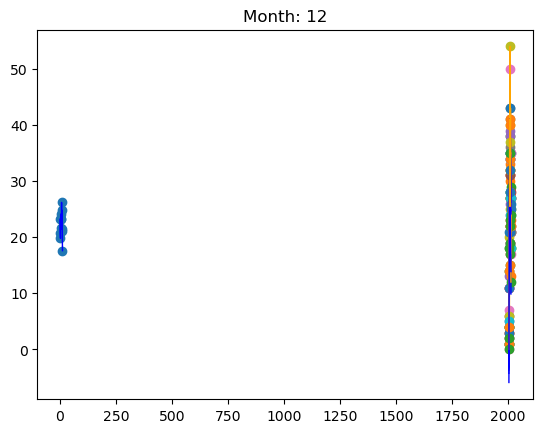

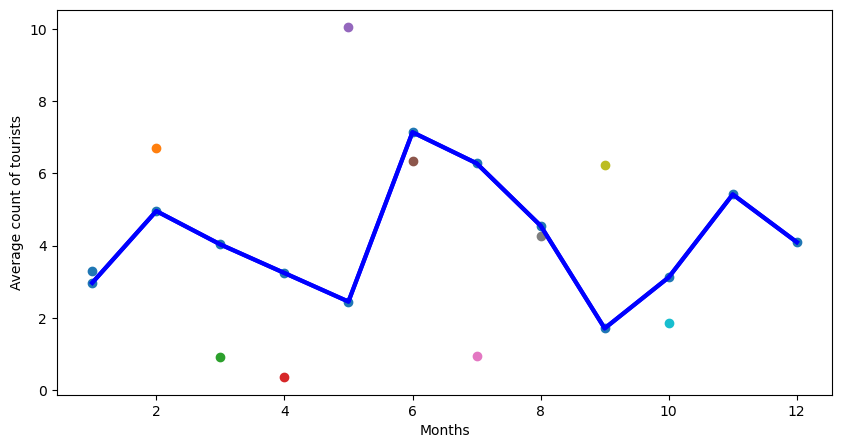

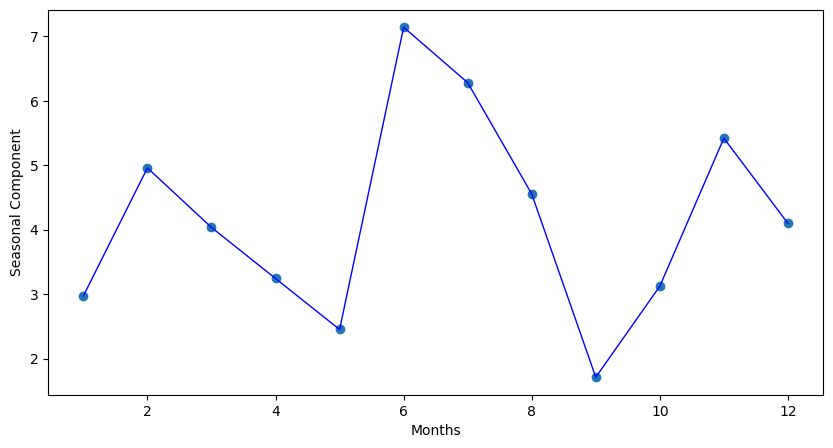

In [21]:
#Time series
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline
import calendar
import sklearn
import sklearn.linear_model as lm

# Opening CSV File corresponding to a particular region
location ="Results/Input records/Filtered1M.csv"
df = pd.read_csv(location, header=None)
df2 = pd.to_datetime(df[5])
months = list(range(1, 13))
df[5] = pd.to_datetime(df[5])
ct = []

# Finding data wrt to each Month
for i in months:
    ct.append(len(df.loc[(df[5].dt.month == i)]))
for i in range(len(ct)):
    ct[i] = ct[i] / 10

months = np.asarray(months)
count = np.asarray(ct)
plt.scatter(months, count)
plt.plot(months, count, color='blue', linewidth=1)
months = list(range(1, 13))
year = list(range(2004, 2014))
allmonths = {}

for i in months:
    allmonths[i] = []
for i in year:
    for j in months:
        allmonths[j].append(len(df.loc[operator.and_(df[5].dt.year == i, df[5].dt.month == j)]))

# Checking value for April
regr = lm.LinearRegression()
sc = []

# Plotting data for each month to find Trend for that particular month

for month in months:
    monthCt = np.asarray(allmonths[month])
    yr = np.asarray(year)

    plt.scatter(year, monthCt)

    poly = make_pipeline(PolynomialFeatures(3), regr)

    poly.fit(yr.reshape(-1, 1), monthCt)

    Y_pred = poly.predict(yr.reshape(-1, 1).reshape(-1, 1))

    plt.plot(year, monthCt, color="orange", linewidth=1)
    plt.plot(year, Y_pred.reshape(-1, 1), color='blue', linewidth=1)

    month_diff = []
    for i in range(len(monthCt)):
        month_diff.append(abs(monthCt[i] - Y_pred[i]))

    sc.append(mean_absolute_error(monthCt, Y_pred))

    plt.title("Month: {}".format(month))
    mean_absolute_error(monthCt, Y_pred)

# Plot of Months with average no. of visitors
fig, ax = plt.subplots(figsize=(10, 5))
month_average_diff = [np.mean(diff) if isinstance(diff, list) else diff for diff in month_diff]

for month in range(1, 13):
    if month <= len(month_diff) and isinstance(month_diff[month-1], list):
        ax.scatter(month, np.asarray(month_diff[month-1]))
    elif month <= len(month_diff):
        ax.scatter(month, month_diff[month-1])
    
ax.scatter(months, np.asarray(sc))
ax.plot(months, np.asarray(sc), color='blue', linewidth=3)

ax.set_xlabel("Months")
ax.set_ylabel("Average count of tourists")

ax.plot(months, np.asarray(sc), color='blue', linewidth=3)

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(months, np.asarray(sc))
ax.set_xlabel("Months")
ax.set_ylabel("Seasonal Component")
ax.plot(months, np.asarray(sc), color='blue', linewidth=1)
